# Panel 1

## Packages

In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
from LRGSG_package.LRGSG_utils import move_to_rootf
#
move_to_rootf(print_tf=True)
plt.style.use('nb/nb_plotsheet.mplstyle')
#
figpath = "data/plot/paper/panel_1/"

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


### Spectral embedding tests ER graph

In [2]:
ergraph = ErdosRenyi(pflip=0.3, n=5, p=0.8)
ergraph.flip_random_fract_edges()

In [3]:
ergraph.G.edges(data='weight')
edge_colors = ['red' if ergraph.G[u][v]['weight'] < 0 else 'black' for u, v in ergraph.G.edges()]
pos = signed_spectral_layout(ergraph.G)
nx.draw(ergraph.G, edge_color=edge_colors, pos=pos, labels={i: i for i in range(nx.number_of_nodes(ergraph.G))})

In [4]:
ergraph.compute_k_eigvV(howmany=3)
# Step 3: Perform eigendecomposition
ergraph.eigV.T
# Step 4: Select eigenvectors for embedding (e.g., 2nd and 3rd smallest)
# Skipping the first eigenvector (corresponding to the smallest eigenvalue)
embedding = ergraph.eigV.T[:, 1:3]


def choose_color(weight):
    return 'red' if weight < 0 else 'green'
# # Step 5: Plot the embedding
plt.scatter(embedding[:, 0], embedding[:, 1])
for i, txt in enumerate(ergraph.G.nodes()):
    plt.annotate(txt, (embedding[i, 0], embedding[i, 1]))

# Draw edges
for edge in ergraph.G.edges():
    x0, y0 = embedding[edge[0]]
    x1, y1 = embedding[edge[1]]
    color = choose_color(ergraph.G.edges[edge]['weight'])
    plt.plot([x0, x1], [y0, y1], color=color, alpha=0.5)  # Draw line for each edge

# Draw nodes
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue')
plt.title("Spectral Embedding of the Graph")
plt.show()

NameError: name 'ergraph' is not defined

In [21]:
ergraph.adjacency_matrix()

<10x10 sparse array of type '<class 'numpy.int64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [17]:
pos = signed_spectral_layout(ergraph.G)

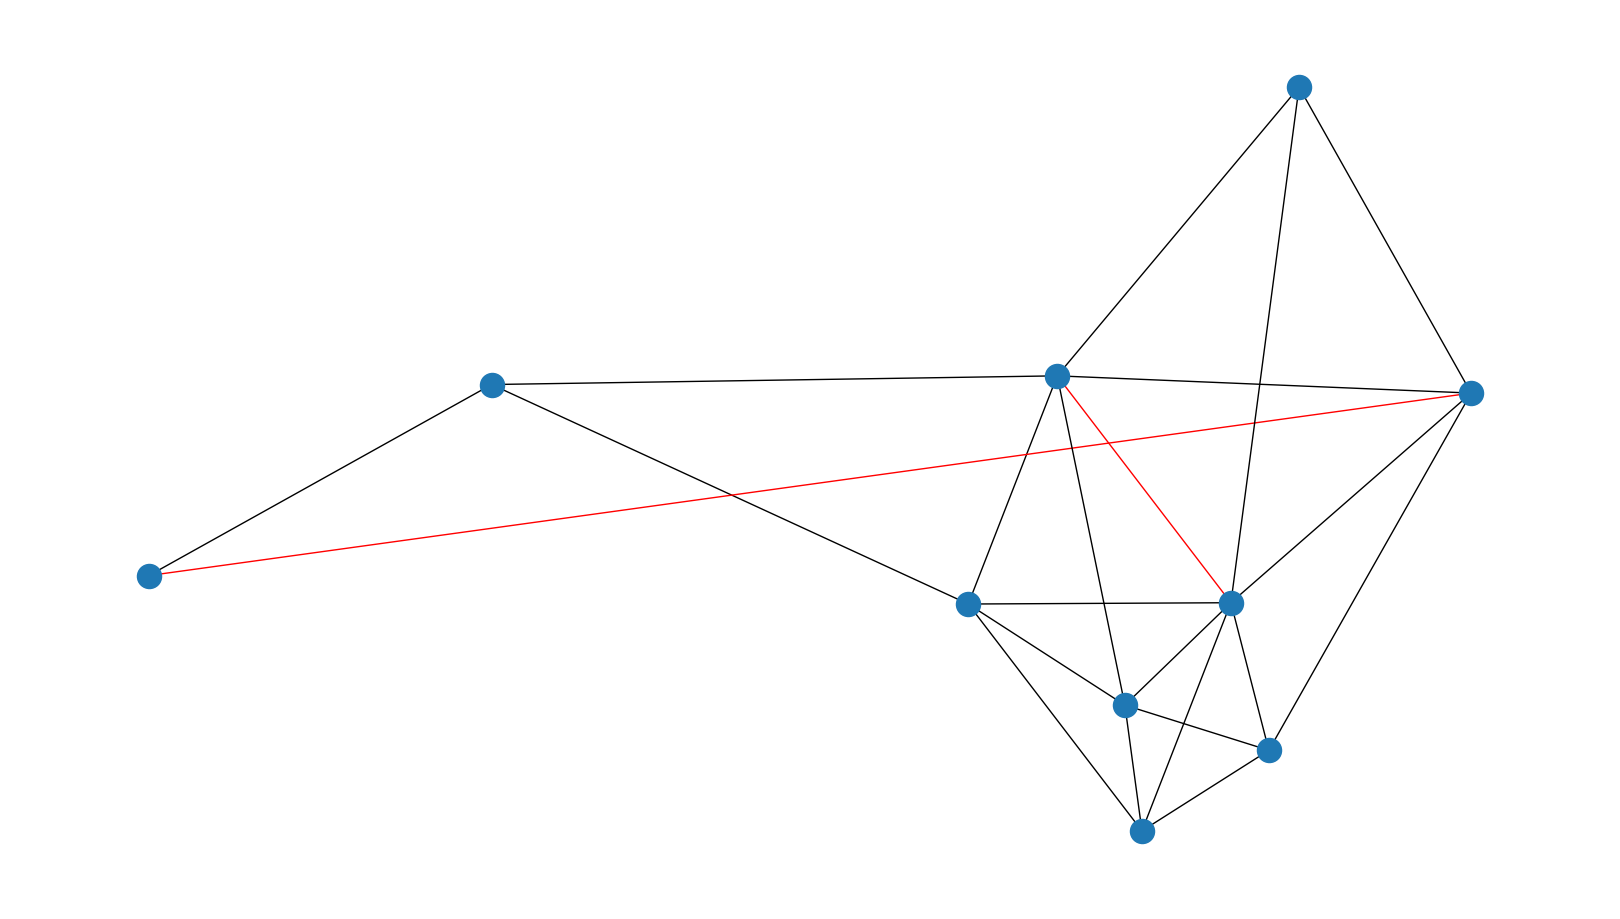

In [18]:
nx.draw(ergraph.G,  pos=pos, edge_color=edge_colors)

### Fig. a
- try to see the lattice eigenvectors with and without PBC

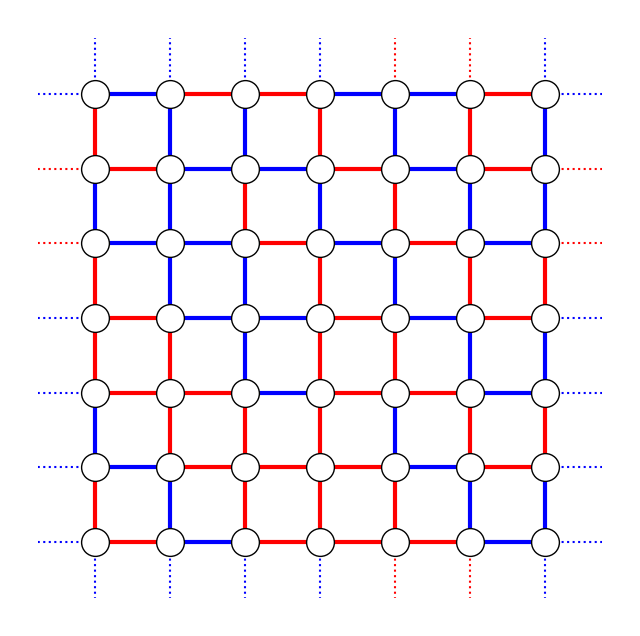

In [2]:
size_grid = 6
fig, ax = plt.subplots(figsize=(8, 8))
plot_square_lattice(ax, size=7)
os.makedirs(figpath, exist_ok=True)
fig.savefig(
    f"{figpath}disordered_grid{size_grid}.pdf",
    bbox_inches="tight",
    pad_inches=-0.1,
    transparent=True
)

### Fig. b

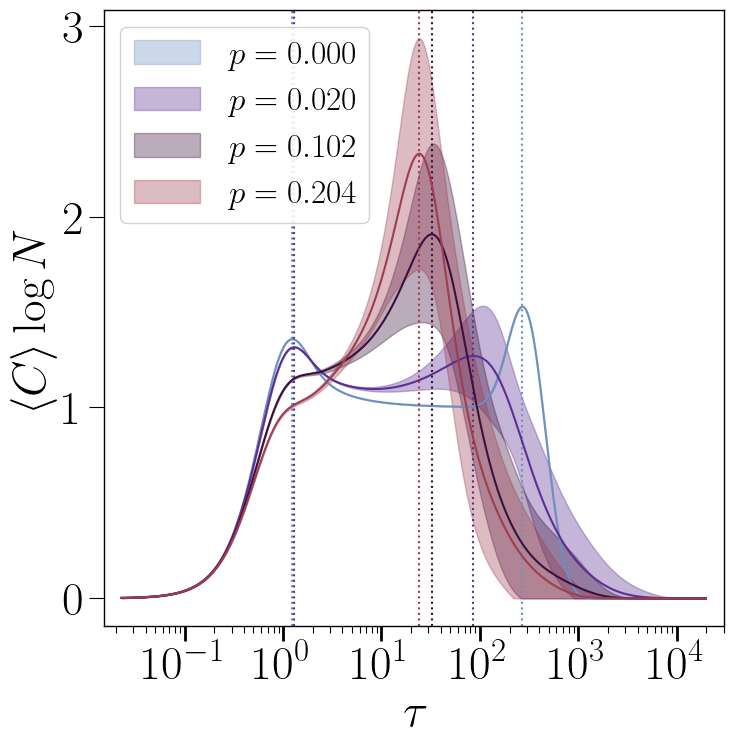

In [4]:
side = 64
number_of_averages = 256
out_suffix = ""
fname = "avgC_"
plist = [0, 0.0204, 0.102, 0.204]#0.408
#
# Choose a colormap
cmap = plt.cm.twilight
colors = cmap(np.linspace(0.2, 0.7, len(plist)))
# Set these colors as the default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
#
fig, ax = plt.subplots(figsize=(8, 8))
#
for p in plist:
    sqlatt = Lattice2D(side1=side, pflip=p, sgpath="l2d_squared_CLUSTER/")
    sla = SignedLaplacianAnalysis(sqlatt, initspect=False)
    #
    fsfx = f"{number_of_averages}_p={sqlatt.pflip:.3g}_{out_suffix}"
    file_path = f"{sqlatt.lrgsgpath}{fname}{fsfx}.npz"
    meanfname = f"{sqlatt.lrgsgpath}meancurve_{fname}{fsfx}.npy"
    stdfname = f"{sqlatt.lrgsgpath}stddev_{fname}{fsfx}.npy"
    #
    if os.path.exists(meanfname) and os.path.exists(stdfname):
        mean_curve = np.load(meanfname)
        std_dev = np.load(stdfname)
    else:
        #
        ld_f = np.load(file_path)
        ld_arr = [
            ld_f[f"arr_{i}"] for i in range(number_of_averages)
        ]
        ld_f.close()
        mean_curve = np.mean(ld_arr, axis=0)
        std_dev = np.std(ld_arr, axis=0)
        with open(meanfname, 'wb') as f:
            np.save(f, mean_curve)
        with open(stdfname, 'wb') as f:
            np.save(f, std_dev)
    mean_curve = gaussian_filter1d(mean_curve[50:-100], sigma=3)  # sigma can be adjusted based on data characteristics
    std_dev = std_dev[50:-100]
    tau = sla.tTsC[50:-100]
    (line,) = ax.plot(tau, mean_curve)
    for imax in argrelextrema(mean_curve, np.greater)[0]:
        ax.axvline(tau[imax], ls=':', color=line.get_color())
    ax.fill_between(
        tau,
        np.maximum((mean_curve - std_dev), 0),
        (mean_curve + std_dev),
        color=line.get_color(),
        alpha=0.35,
        zorder=line.get_zorder() - 1,
        label=rf"$p={p:.3f}$",
    )

ax.set_xscale("log")
ax.set_ylabel(r"$\avg{C}\log N$")
ax.set_xlabel(r"$\tau$")
ax.legend(fontsize=24, loc="upper left")
ax.xaxis.get_major_locator().set_params(numticks=8)
ax.xaxis.get_minor_locator().set_params(
    numticks=10, subs=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
)
ax.set_xlim([1.5e-2, 3e4])
fig.savefig(
    f"{figpath}avgC{side}_{number_of_averages}.pdf",
    bbox_inches="tight",
    transparent=True,
)

### Fig. c

In [15]:
side = 45
navg = 20000
sqlatt = Lattice2D(side1=side, geometry="squared", sgpath="l2d_squared_CLUSTER/")
#
plist = lsp_read_values(sqlatt.lrgsgpath, fpattern=f"Sm1_avg{navg}_p")
tll = 0.098
tul = 0.105
#
to_slice_1 = [1, 28]
slice_1 = first_index_changing_condition(plist < tll)
slice_2 = first_index_changing_condition(plist < tul)
slice_2_to_end = len(plist)-slice_2
slice_full = np.r_[0,
                   slice_1:slice_2, 
                   slice_2:len(plist):slice_2_to_end//4]
plist = plist[slice_full]
#
plistmid = plist[(tll < plist) & (plist < tul)]
plistmid_len = len(plistmid)
plisteff_len = len(plist)-plistmid_len

/tmp/ipykernel_7522/1829765035.py:22: RuntimeWarning: divide by zero encountered in log
  energy = -np.log(y_normalized)


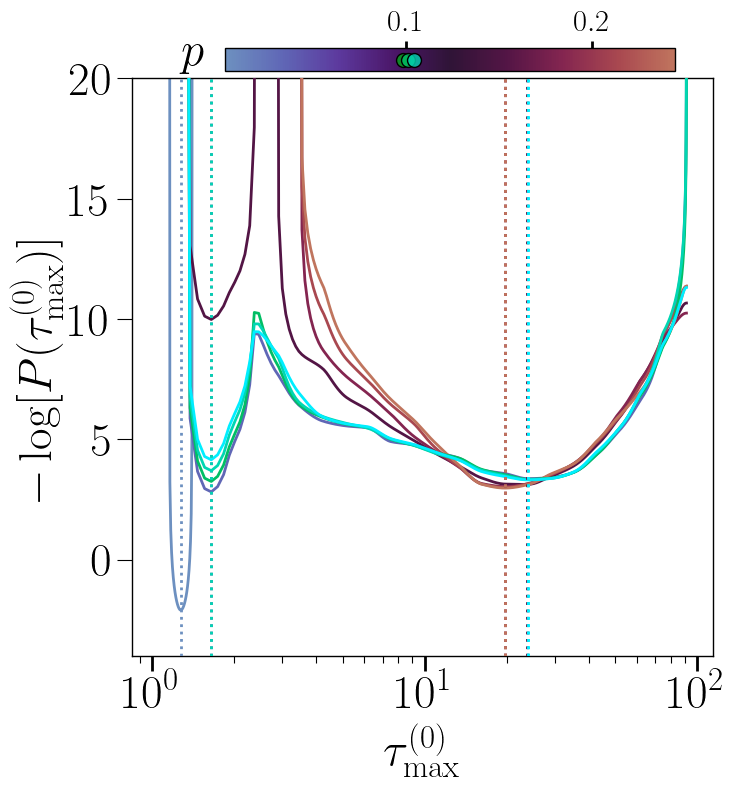

In [25]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

#
cmap = plt.cm.twilight
cmap_val = cmap(np.linspace(0.2, 0.8, len(plist)))
custom_cmap = LinearSegmentedColormap.from_list("custom_twilight", cmap_val)
cmap_tra = create_custom_colormap(c1="#02a618", c2="#00eeff")
cmap_nrm = Normalize(vmin=plist.min(), vmax=plist.max())
#
ax.set_ylabel(r"$-\log[P(\tau_{\max}^{(0)})]$")
ax.set_xlabel(r"$\tau_{\max}^{(0)}$")
#
cntr = 1
for i, p in enumerate(plist):
    taumax = np.fromfile(f"{sqlatt.lrgsgpath}tau_max0_avg{navg}_p={p:.3g}.bin")
    bin_centers, hist, bw = log_binning(taumax, 25)
    #
    pch = pchip(bin_centers, hist)
    xx = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    total_area = np.trapz(pch(xx), x=xx)
    y_normalized = pch(xx) / total_area
    energy = -np.log(y_normalized)
    energy[energy == np.inf] = 100
    #
    if tll < p < tul:
        kwargs = {'color': cmap_tra(cntr/plistmid_len), 'zorder': 100, 
                  'label': fr'${p:.3g}$', 'lw': 2}
        cntr += 1
        ax.axvline(xx[np.argmin(energy[~np.isnan(energy)])], ls=':', lw=2, color=cmap_tra(cntr/plistmid_len), zorder=200)
    else:
        kwargs = {'color': cmap_val[i], 'zorder': i, 
                  'label': '', 'lw': 2}
        ax.axvline(xx[np.argmin(energy[~np.isnan(energy)])], ls=':', lw=2, color=cmap_val[i], zorder=100)
    #
    ax.plot(xx, energy, '-', **kwargs)
ax.set_ybound(lower=-4, upper=20)
ax.set_xscale('log')
#
cbar_ax = fig.add_axes([0.25, 0.89, 0.6, 0.03])
clb = fig.colorbar(ScalarMappable(norm=cmap_nrm, cmap=custom_cmap), cax=cbar_ax, orientation='horizontal')
# clb.ax.set_title(r'$p$', pad=10)
for i, p in enumerate(plist[(tll < plist) & (tul > plist)]):
    cbar_ax.plot(p, 0.5, 'o', mec='k', ms=10, 
                mfc = set_alpha_torgb(cmap_tra(i/plistmid_len), 0.8))
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.set_ylabel(r'$p$', rotation=360, labelpad=25)
ylabel = cbar_ax.yaxis.get_label()
x, y = ylabel.get_position()
ylabel.set_position((x, y - .6))  # This moves the label up

cbar_ax.tick_params(axis='x', which='both', length=5, labelsize=22) 

#
fig.savefig(f'{figpath}squared_lattice_taumaxdistri.pdf', 
            bbox_inches='tight', transparent=True)

### Misc

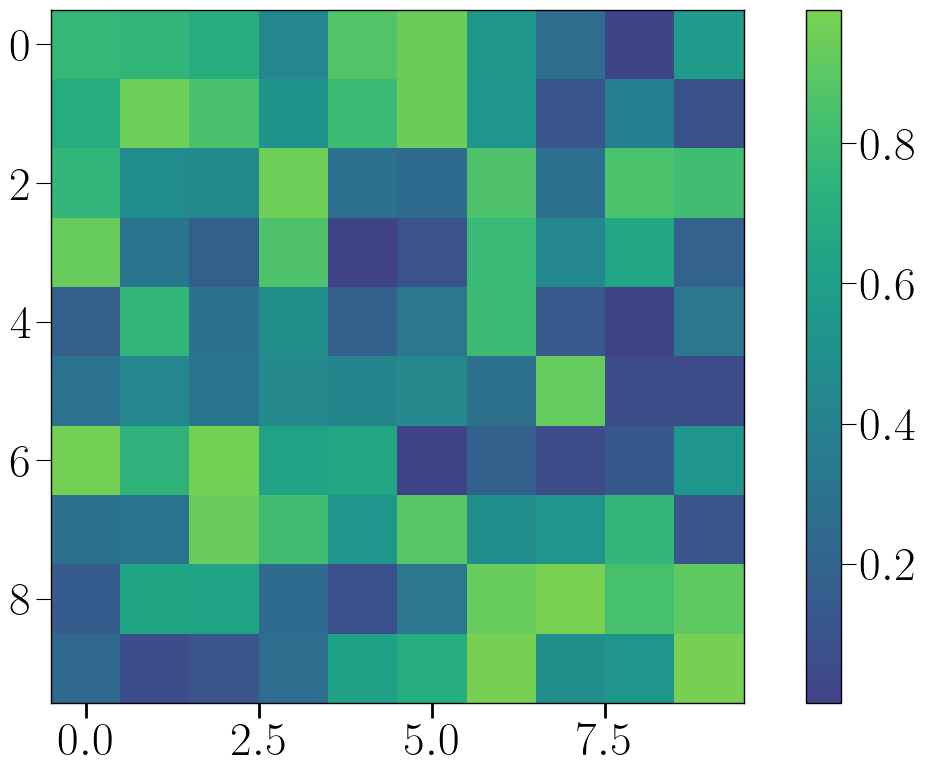

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Choose an existing colormap
base_cmap = plt.cm.viridis

# Define the start and end limits (between 0 and 1) for the new colormap
start = 0.2
end = 0.8

# Create a new colormap from the subset of the original colormap
new_cmap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_cmap.name, a=start, b=end),
    base_cmap(np.linspace(start, end, 256))
)

# Test the new colormap
x = np.random.rand(10,10)
plt.imshow(x, cmap=new_cmap)
plt.colorbar()
plt.show()


In [4]:
# fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
# y_values = ld_arr[:]
# if type(y_values) is np.ndarray:
#     ax[0].plot(sla.tTsC, y_values)
# elif type(y_values) is list:
#     for i in y_values:
#         ax[0].plot(sla.tTsC, i)
# ax[0].set_xscale('log')
# ax[0].plot(sla.tTsC, np.mean(ld_arr, axis=0), 'k')
# # thresh = 2e-2
# # sel_vals = [y_values for y_values in loaded_arrays if all(y_values[np.where(np.abs(np.diff(y_values)) == y_values[:-1])] < thresh)]
# for y_values in ld_arr:
#     ax[1].plot(sla.tTsC, y_values)
# std_dev = np.std(ld_arr, axis=0)
# mean_curve = np.mean(ld_arr, axis=0)
# ax[1].plot(sla.tTsC, mean_curve, 'k')
# ax[0].fill_between(sla.tTsC, np.maximum(mean_curve - std_dev, 0), mean_curve + std_dev, color='gray', alpha=0.75, label='Standard Deviation', zorder=10)

# ax[1].set_xscale('log')
# ax[1].set_ylim(-0.05, 0.1)
# ax[1].set_xlim(1e3, 1e4)

In [5]:
# listplot = []
# for i in range(10):
#     sqlatt = Lattice2D(
#         side1=64, 
#         pflip=0.11)
#     sqlatt.flip_random_fract_edges()
#     sla = SignedLaplacianAnalysis(sqlatt)
#     sla.computeC()
#     listplot.append([sla.tTsC, sla.Cspe])
# for i in range(10):
#     plt.plot(listplot[i][0], medfilt(listplot[i][1]))
# plt.xscale('log')

In [6]:
# def plot_average(data):
#     """
#     Plots the pointwise average of y-coordinates against x-coordinates.

#     Parameters:
#     -----------
#     data : list of lists
#         Each sublist contains two arrays: [x-coordinates, y-coordinates].

#     Returns:
#     --------
#     None
#         The function creates a plot.

#     Raises:
#     -------
#     ValueError
#         If x-coordinates in the data are not identical.

#     Example:
#     --------
#     data = [
#         [np.array([1, 2, 3]), np.array([2, 3, 4])],
#         [np.array([1, 2, 3]), np.array([4, 5, 6])]
#     ]
#     plot_average(data)
#     """
#     # Check if all x-coordinates are identical
#     x_coords = [item[0] for item in data]
#     if not all(np.array_equal(x_coords[0], x) for x in x_coords):
#         raise ValueError("All x-coordinates must be identical for pointwise averaging")

#     # Compute pointwise average of y-coordinates
#     y_coords = [item[1] for item in data]
#     avg_y = np.mean(y_coords, axis=0)
#     return x_coords[0], avg_y
#     # Plot the average y-coordinates against x-coordinates

# from scipy import interpolate

# def remove_spikes(x, y, threshold):
#     # Identify outliers
#     diff = np.abs(np.diff(y, n=1))
#     indices = np.where(diff > threshold)[0]

#     # Remove outliers
#     x_new = np.delete(x, indices+1)
#     y_new = np.delete(y, indices+1)

#     # Interpolate
#     f = interpolate.interp1d(x_new, y_new, kind='cubic')
#     y_smooth = f(x)

#     return y_smooth
# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# from scipy.signal import medfilt

# def median_filter(data, kernel_size=3):
#     return medfilt(data, kernel_size=kernel_size)

# import matplotlib.pyplot as plt
# import numpy as np

# # Example data with spikes
# x = np.linspace(0, 10, 1000)
# y = np.sin(x)  # Adding noise
# y[::10] += 3  # Adding spikes

# # Smooth the data
# y_smooth = remove_spikes(x, y, threshold=1.5)  # Change the threshold as needed
# y_smooth2 = moving_average(y, 20)
# y_smooth3 = medfilt(y)

# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(x, y, label='Original Data')
# plt.plot(x, y_smooth, label='Smoothed Data', color='red')
# plt.plot(x[:-(20-1)], y_smooth2, label='Smoothed Data', color='purple')
# plt.plot(x, y_smooth3, label='Smoothed Data', color='green')
# plt.legend()
# plt.show()

### Fig. d

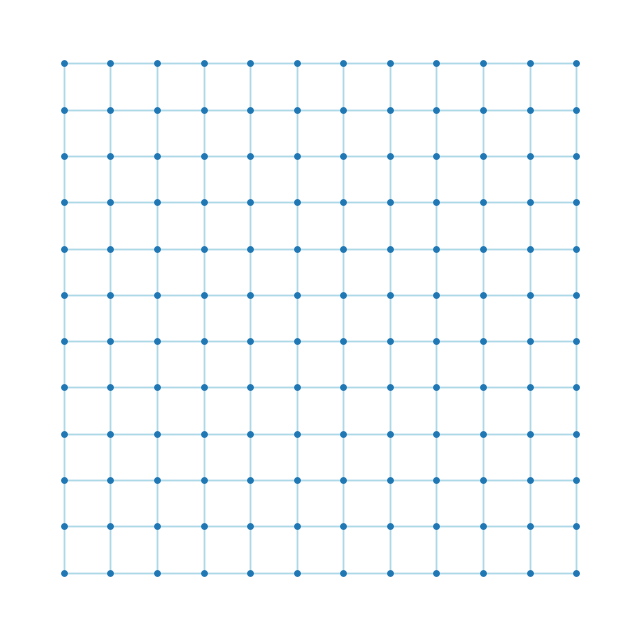

In [5]:
side = 12
sqlatt = Lattice2D(#
    side1 = side,
    geometry = 'squared',
)

G = sqlatt.G
G_edges_ww = G.edges(data='weight')
edgecol = ['lightblue' if e[2] > 0 else 'r' for e in G_edges_ww]

fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G, 
        pos=sqlatt.posG, 
        ax=ax,  
        edge_color=edgecol, 
        node_color=None,  
        node_size=15,
        with_labels=False)